In [1]:
import numpy as np
from matplotlib import pyplot as plt
import ipywidgets

import discretize
from discretize.utils import mesh_builder_xyz, refine_tree_xyz

from SimPEG.potential_fields import magnetics as mag
from SimPEG import (
    data,
    data_misfit,
    directives,
    maps,
    inverse_problem,
    optimization,
    inversion,
    regularization,
    utils
)

# Forward problem

## define the geologic setup

**SimPEG conventions**
- right handed coordinate system
- z-positive up
- SI units

For this example, we assume flat topography with the surface at z=0

In [2]:
# define geology

target_geometry = np.array([
    [-50, 50],  # x
    [-50, 50],  # y
    [-150, -50]  # z
]).T

target_magnetization_inclination = 45
target_magnetization_declination = 90 

target_magnetization_direction = utils.mat_utils.dip_azimuth2cartesian(
    target_magnetization_inclination, target_magnetization_declination
)

target_magnetization_amplitude = 100 # magnetization in A/m
target_magnetization = target_magnetization_amplitude * target_magnetization_direction

## survey geometry

In [3]:
line_length = 500
n_data_along_line = 25

survey_x = np.linspace(-line_length/2, line_length/2, n_data_along_line)
survey_y = np.r_[0]
survey_z = np.r_[10]

survey_xyz = discretize.utils.ndgrid([survey_x, survey_y, survey_z])

## create a mesh

Here, for simplicity, we use a tensor mesh. If we end up working with larger problems, we should switch to an OcTree. 

In [4]:
cell_widths = np.r_[20, 20, 20]

padding_distance = 200 * np.ones((3, 2))

mesh = mesh_builder_xyz(
    survey_xyz, cell_widths, padding_distance, 
    depth_core=0,
    mesh_type="tree"
)
mesh.x0 = -np.array([mesh._h[i].sum() for i in range(3)]) / 2.

# refine near survey locations & target location
mesh = refine_tree_xyz(
    mesh, 
    discretize.utils.ndgrid([
        survey_x, 
        np.r_[np.min(np.hstack([target_geometry[:, 1], survey_y])), np.max(np.hstack([target_geometry[:, 1], survey_y]))],
        np.r_[target_geometry.min(), survey_z.max()]
    ]), 
    method="box", 
    octree_levels=[4, 4],
    finalize=True
)

ind_active = mesh.cell_centers_z < 0

In [5]:
mesh

OcTreeMesh: 7.63% filled

Level : Number of cells               Mesh Extent               Cell Widths    
-----------------------           min     ,     max            min   ,   max   
  3   :       56             ---------------------------   --------------------
  4   :       400         x:    -640.0    ,    640.0          20.0   ,   160.0   
  5   :       960         y:    -320.0    ,    320.0          20.0   ,   160.0   
  6   :      3584         z:    -320.0    ,    320.0          20.0   ,   160.0   
-----------------------
Total :      5000

### put the model on the mesh 

In [6]:
ind_target = (
    (mesh.cell_centers[:, 0] >= target_geometry[:, 0].min()) & 
    (mesh.cell_centers[:, 0] <= target_geometry[:, 0].max()) &
    (mesh.cell_centers[:, 1] >= target_geometry[:, 1].min()) & 
    (mesh.cell_centers[:, 1] <= target_geometry[:, 1].max()) &
    (mesh.cell_centers[:, 2] >= target_geometry[:, 2].min()) & 
    (mesh.cell_centers[:, 2] <= target_geometry[:, 2].max())
)

magnetization = np.zeros((mesh.nC, 3))
magnetization[ind_target, :] = target_magnetization

create an active cell map to ignore air cells (not as important in the forward, but will be in the inversion)

In [7]:
ind_active = mesh.cell_centers[:, 2] <= 0
magnetization[~ind_active, :] = np.nan

model = magnetization[ind_active, :]
active_cell_map = maps.InjectActiveCells(mesh=mesh, indActive=ind_active, valInactive=np.nan)

plot the model

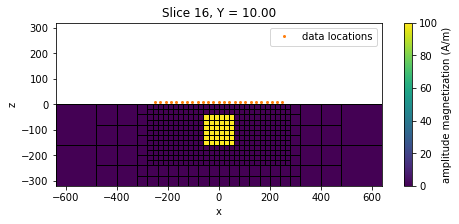

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(8, 3))
cb = plt.colorbar(mesh.plot_slice(
    np.linalg.norm(magnetization, axis=1), normal="Y", ax=ax, grid=True, 
)[0], ax=ax)

ax.plot(survey_x, survey_z*np.ones_like(survey_x), "C1o", ms=2, label="data locations")
ax.legend()

cb.set_label("amplitude magnetization (A/m)")
ax.set_aspect(1)

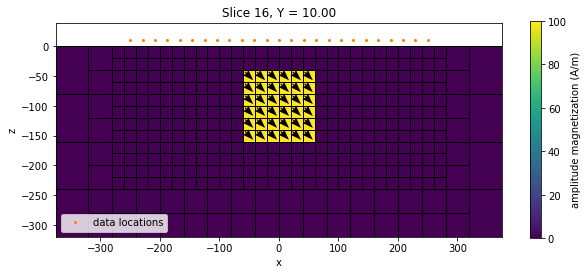

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))

cb = plt.colorbar(
    mesh.plot_slice(
        magnetization, "CCv", normal="Y", ax=ax, view="vec", grid=True, 
        quiver_opts={
            "units":"xy", "scale":np.linalg.norm(target_magnetization)/20,
            "headwidth":7, "headlength":10, "headaxislength":9
        }
    )[0][0], ax=ax
)
cb.set_label("amplitude magnetization (A/m)")

ax.plot(survey_xyz[:, 0], survey_xyz[:, 2], "C1o", ms=2, label="data locations")
ax.legend()

ax.set_xlim([survey_x.min()*1.5, survey_x.max()*1.5])
ax.set_ylim([mesh.nodes_z.min(), survey_z.max()*4])
ax.set_aspect(1)

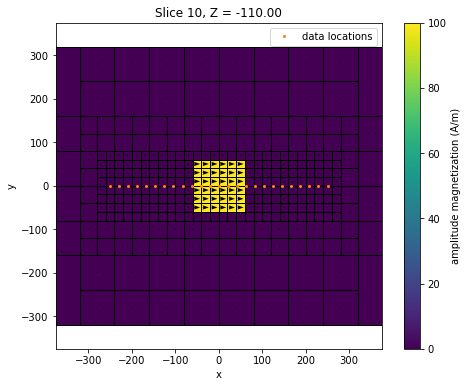

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

cb = plt.colorbar(
    mesh.plot_slice(
        magnetization, "CCv", ind=10,
        normal="Z", ax=ax, view="vec", grid=True, 
        quiver_opts={
            "units":"xy", "scale":np.linalg.norm(target_magnetization)/20,
            "headwidth":7, "headlength":10, "headaxislength":9
        }
    )[0][0], ax=ax
)
cb.set_label("amplitude magnetization (A/m)")

ax.plot(survey_xyz[:, 0], survey_xyz[:, 1], "C1o", ms=2, label="data locations")
ax.legend()

ax.set_xlim([survey_x.min()*1.5, survey_x.max()*1.5])
ax.set_ylim([survey_x.min()*1.5, survey_x.max()*1.5])
ax.set_aspect(1)

## setup and run the forward simulation

### survey

We create a survey object that keeps track of what data we are measuring and where. We create a `source_field` because the code was designed thinking about "effective susceptibility" being the model parameter. The orientation makes no impact, it is only a scaling. So since the problem is linear, if we use an amplitude of 1 for the source field, then we can consider the model to be magnetization, and there is no induced component. 

In [13]:
components = ["x", "y", "z"]
rx = mag.receivers.Point(locations=survey_xyz, components=[f"b{comp}" for comp in components])

source_field = mag.sources.SourceField(
    receiver_list=[rx], parameters=np.r_[1., 0, 0]
)
survey = mag.survey.Survey(source_field)

### simulation 

The simulation object is what we use to create our synthetic data

In [14]:
simulation = mag.simulation.Simulation3DIntegral(
    mesh=mesh, survey=survey, chiMap=maps.IdentityMap(nP=np.prod(model.shape)), 
    actInd=ind_active, modelType="vector"
)

### run the simulation

In [15]:
synthetic_data = simulation.make_synthetic_data(
    utils.mkvc(model), 
    noise_floor=1, # standard deviation of the noise in nT
    relative_error=0, 
    add_noise=True
) 

In [16]:
survey_xyz.shape

(25, 3)

In [17]:
dclean = synthetic_data.dclean.reshape((survey_xyz.shape[0], len(components)))
dnoisy = synthetic_data.dobs.reshape((survey_xyz.shape[0], len(components)))

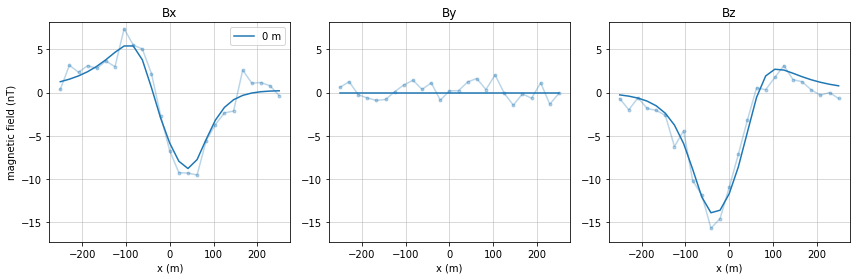

In [18]:
fig, ax = plt.subplots(1, len(components), figsize=(4*len(components), 4))

for i, component in enumerate(components):
    dc = dclean[:, i].reshape(len(survey_x), len(survey_y), order="F")
    dn = dnoisy[:, i].reshape(len(survey_x), len(survey_y), order="F")
    for j, y in enumerate(survey_y):
        ax[i].plot(survey_x, dc[:, j], f"C{j}", ms=3, label=f"{y:1.0f} m")
        ax[i].plot(survey_x, dn[:, j], f"C{j}", marker="o", ms=3, alpha=0.3)
    ax[i].set_title(f"B{component}")
    ax[i].grid("both", alpha=0.6)
    ax[i].set_ylim(1.1 * np.r_[synthetic_data.dobs.min(), synthetic_data.dobs.max()])
    ax[i].set_xlabel("x (m)")
    
ax[0].set_ylabel("magnetic field (nT)")
ax[0].legend()
plt.tight_layout()

In [19]:
if len(survey_y) > 1: 
    fig, ax = plt.subplots(2, len(components), figsize=(4*len(components), 5), sharex=True, sharey=True)

    for i, component in enumerate(components):
        out = utils.plot2Ddata(survey_xyz, dclean[:, i], ax=ax[0, i])
        ax[0, i].set_title(f"B{component} clean")
        ax[0, i].plot(survey_xyz[:, 0], survey_xyz[:, 1], "k.", ms = 2)

        out = utils.plot2Ddata(survey_xyz, dnoisy[:, i], ax=ax[1, i])
        ax[1, i].plot(survey_xyz[:, 0], survey_xyz[:, 1], "k.", ms = 2)
        ax[0, i].set_title(f"B{component} noisy")
        ax[1, i].set_xlabel("x (m)")

    ax[0, 0].set_ylabel("y (m)")
    ax[1, 0].set_ylabel("y (m)")

    plt.tight_layout()

## Inversion 

### in cartesian coordinates 
This is a linear inverse problem if we use L2 regularization. Here, we will use the sparse regularization (which first solves the L2 problem), so we can compare. 

In [20]:
# create the regularization
n_active = int(ind_active.sum())
wires = maps.Wires(("x", n_active), ("y", n_active), ("z", n_active))

reg_x = regularization.Sparse(mesh, indActive=ind_active, mapping=wires.x)
reg_y = regularization.Sparse(mesh, indActive=ind_active, mapping=wires.y)
reg_z = regularization.Sparse(mesh, indActive=ind_active, mapping=wires.z)

norms = [[0, 0, 0, 0]]
reg_x.norms = norms
reg_y.norms = norms
reg_z.norms = norms

reg = reg_x + reg_y + reg_z

In [21]:
# data misfit
dmis = data_misfit.L2DataMisfit(data=synthetic_data, simulation=simulation)

In [22]:
# optimization
opt = optimization.InexactGaussNewton(
    maxIter=10, maxIterLS=20, maxIterCG=20, tolCG=1e-4
)

In [23]:
# inverse problem
inv_prob = inverse_problem.BaseInvProblem(dmis, reg, opt)

In [24]:
# directives 

# A list of directive to control the inverson
betaest = directives.BetaEstimate_ByEig(beta0_ratio=2)

# Add sensitivity weights
sensitivity_weights = directives.UpdateSensitivityWeights()

# Here is where the norms are applied
# Use a threshold parameter empirically based on the distribution of
#  model parameters
IRLS = directives.Update_IRLS(f_min_change=1e-3, max_irls_iterations=5, beta_tol=1e-1)

# Pre-conditioner
update_Jacobi = directives.UpdatePreconditioner()

In [25]:
inv = inversion.BaseInversion(
    inv_prob, directiveList=[sensitivity_weights, IRLS, update_Jacobi, betaest]
)

### run the inversion

In [26]:
m0 = np.zeros(n_active * 3)

In [27]:
mrec_cartesian = inv.run(m0)

SimPEG.InvProblem will set Regularization.mref to m0.
SimPEG.InvProblem will set Regularization.mref to m0.
SimPEG.InvProblem will set Regularization.mref to m0.

        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
        ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  1.91e-02  7.77e+02  0.00e+00  7.77e+02    9.23e+00      0              
Reached starting chifact with l2-norm regularization: Start IRLS steps...
eps_p: 11.935147515935308 eps_q: 11.935147515935308
eps_p: 11.300742606066235 eps_q: 11.300742606066235
eps_p: 12.444155191685095 eps_q: 12.444155191685095
   1  9.56e-03  2.49e+01  4.33e+03  6.63e+01    3.18e-01      0              
   2  1.84e-02  2.03e+01  6.53e+

In [28]:
def full_mesh_magnetization(model):
    return np.vstack([active_cell_map * model.reshape(n_active, 3, order="F")[:, i] for i in range(3)]).T

In [29]:
magnetization_cartesian_sparse = full_mesh_magnetization(mrec_cartesian)
magnetization_cartesian_smooth = full_mesh_magnetization(inv_prob.l2model)

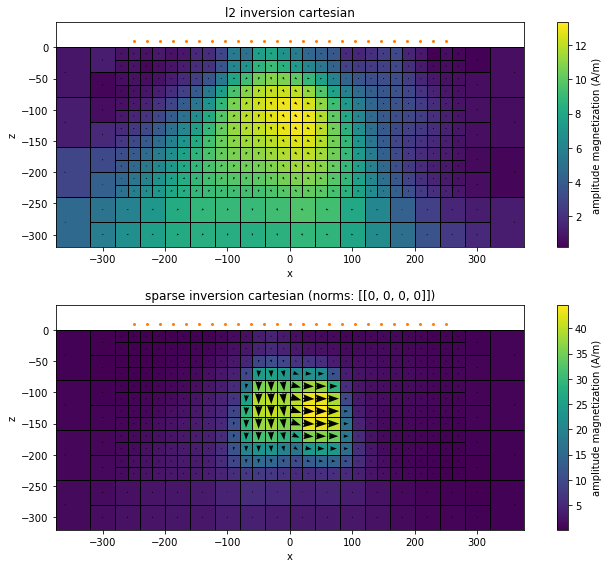

In [31]:
fig, ax = plt.subplots(2, 1, figsize=(10, 8))


cb = plt.colorbar(
    mesh.plot_slice(
        magnetization_cartesian_smooth, "CCv", normal="Y", ax=ax[0], view="vec", grid=True, 
        quiver_opts={
            "units":"xy", "scale":np.max(np.abs(mrec_cartesian))/20,
            "headwidth":7, "headlength":10, "headaxislength":9
        }
    )[0][0], ax=ax[0]
)
cb.set_label("amplitude magnetization (A/m)")
ax[0].set_title("l2 inversion cartesian")

cb = plt.colorbar(
    mesh.plot_slice(
        magnetization_cartesian_sparse, "CCv", normal="Y", ax=ax[1], view="vec", grid=True, 
        quiver_opts={
            "units":"xy", "scale":np.max(np.abs(mrec_cartesian))/20,
            "headwidth":7, "headlength":10, "headaxislength":9
        }
    )[0][0], ax=ax[1]
)
cb.set_label("amplitude magnetization (A/m)")
ax[1].set_title(f"sparse inversion cartesian (norms: {norms})")

plt.tight_layout()

for a in ax: 
    a.plot(survey_xyz[:, 0], survey_xyz[:, 2], "C1o", ms=2, label="data locations")
    a.set_xlim([survey_x.min()*1.5, survey_x.max()*1.5])
    a.set_ylim([mesh.nodes_z.min(), survey_z.max()*4])
    a.plot()
    a.set_aspect(1)